In [1]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
pd.options.mode.chained_assignment = None  # default='warn'
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from scipy.sparse import vstack


C:\Users\123\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Ссылка на соревнование Kaggle https://www.kaggle.com/competitions/spaceship-titanic

<h3 align='left'>Функция формирования посылки на Kaggle</h3>

In [2]:
def kaggle_sub(y_pred):
    submission = pd.read_csv('sample_submission.csv')
    submission['Transported'] = y_pred
    submission.to_csv('submission', index=False)

<h3 align='left'>Считывание и начальная предобработка данных</h3>

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [6]:
train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [7]:
test.isnull().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

<h3 align='left'>Предобработка </h3>

In [8]:
#Удалим пропуски в CryoSleep, т.к. это наиболее влияющий на перенос в другое измерение параметр (см. график ниже)
train = train.dropna(subset='CryoSleep')
#Объединяем train и test
data = pd.concat([train, test], axis=0)
train_size = train.shape[0]
#разделяем место на deck/num/side
data = pd.concat([data, data['Cabin'].str.split('/', expand=True).rename(columns={0: 'Deck', 1: 'Num', 2: 'Side'}), 
                 #разделяем id на group/id
                 data['PassengerId'].str.split('_', expand=True).rename(columns={0: 'Group', 1: 'ID_in_group'})], axis=1) 
y_train_full = train['Transported']

In [9]:
#Заполняем пропущенные значения
objects = data.columns[data.dtypes == 'object']
floats = data.columns[data.dtypes == 'float']

data[floats] = data[floats].fillna(data.median())

data['HomePlanet'] = data['HomePlanet'].fillna(data.describe(include='all')['HomePlanet'].top)
data['CryoSleep'] = data['CryoSleep'].fillna(data.describe(include='all')['CryoSleep'].top).map({True: 1, False: 0})
data['Destination'] = data['Destination'].fillna(data.describe(include='all')['Destination'].top)
data['VIP'] = data['VIP'].fillna(data.describe(include='all')['VIP'].top).map({False: 0, True: 1})

C:\Users\123\AppData\Local\Temp\ipykernel_11536\3102621403.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data[floats] = data[floats].fillna(data.mean())


<h3 align='left'>Визуализация</h3>

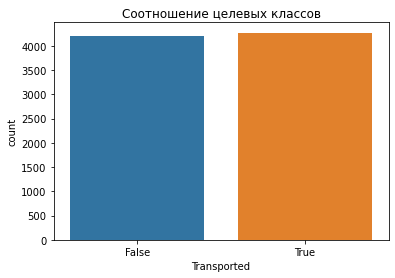

In [10]:
#Оценим соотношение классов
graph_df = data.iloc[:train_size]
sns.countplot(x=graph_df['Transported'])
plt.title('Соотношение целевых классов');

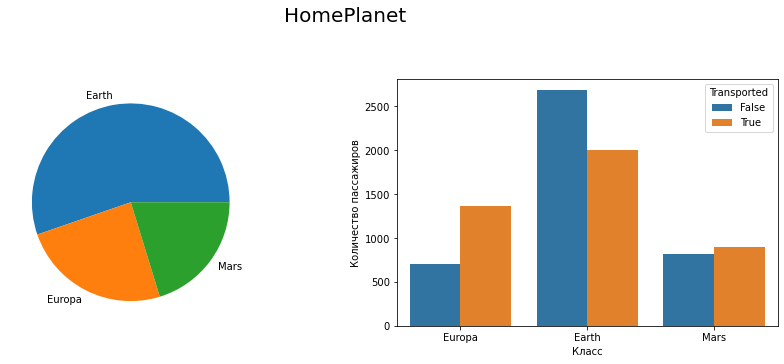

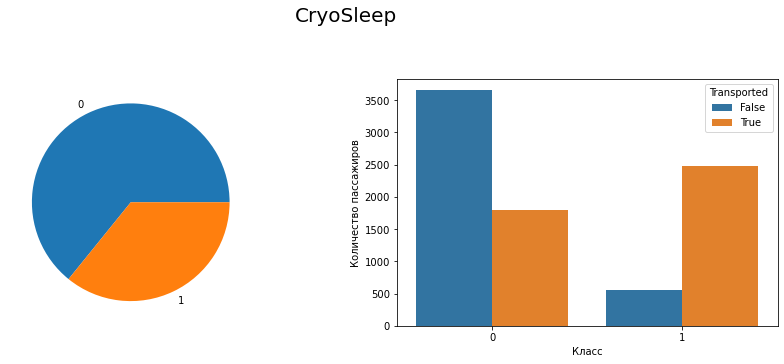

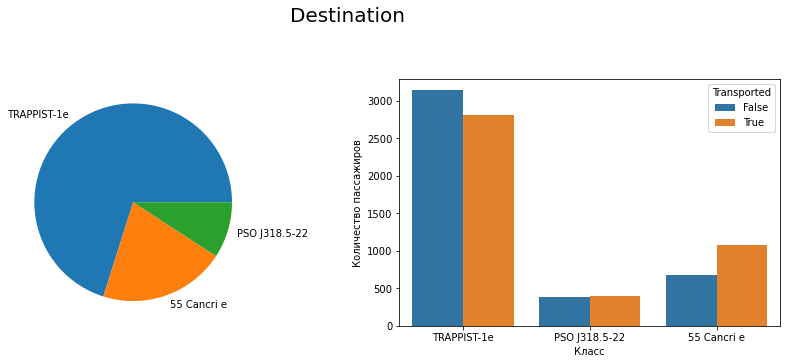

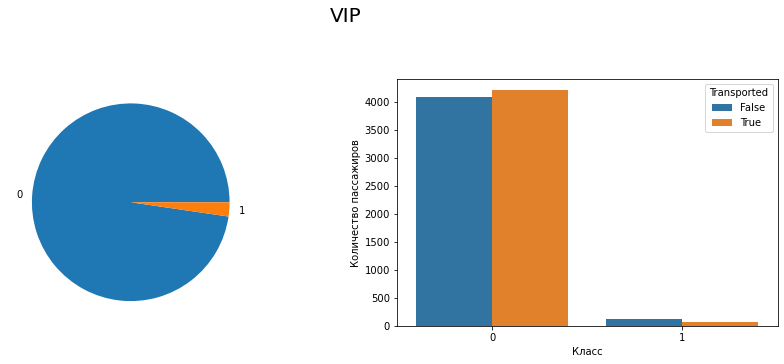

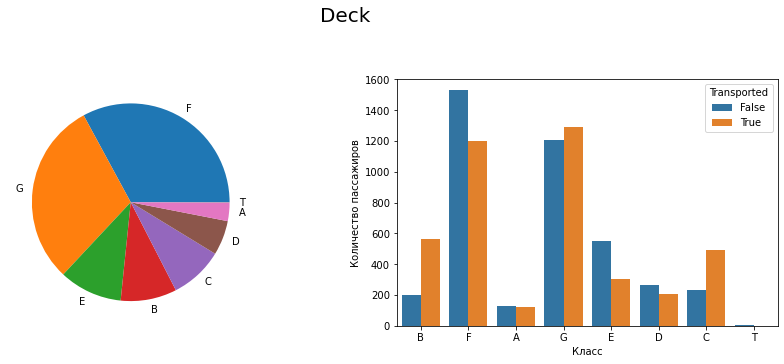

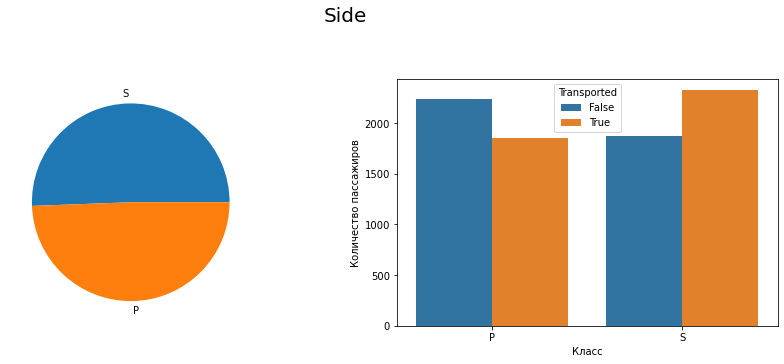

In [11]:
#Соотношение классов в категориальных признаках, количество перенесенных/неперенесенных в другое измерение 
#пассажиров внутри классов
objects_graph = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']
for i in objects_graph:
    plt.figure(figsize=(15, 10)).suptitle(i, fontsize = 20)    
    plt.title(i, pad=0)
    plt.subplot(2, 2, 2)
    sns.countplot(x=graph_df[i], hue = graph_df['Transported'].iloc[:train_size])
    plt.ylabel('Количество пассажиров')
    plt.xlabel('Класс');
    plt.subplot(2, 2, 1)
    plt.pie(x=graph_df[i].value_counts(), 
            labels=graph_df[i].value_counts().index.to_list())
    ;

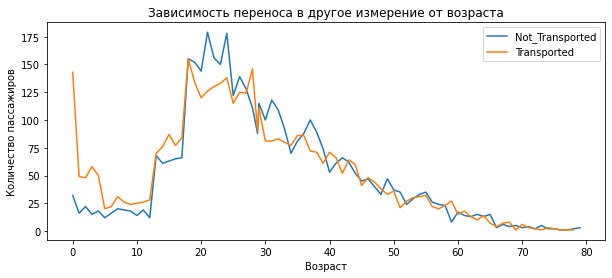

In [12]:
#Зависимость переноса в другое измерение от возраста
plt.figure(figsize=(10, 4))
plt.plot(graph_df[graph_df['Transported'] == 0].groupby(['Age'])['Transported'].count(), label='Not_Transported')
plt.plot(graph_df[graph_df['Transported'] == 1].groupby(['Age'])['Transported'].count(), label='Transported')
plt.legend()
plt.title('Зависимость переноса в другое измерение от возраста')
plt.ylabel('Количество пассажиров')
plt.xlabel('Возраст');

Чаще переносились в другое измерение \
Жители Европы и Марса \
Пассажиры, находящиеся в креосне \
Пассажиры, летящие на планеты PSO* и Cancri* \
Пассажиры палуб B, C, G \
Пассажиры борта S \
Маленькие дети

VIP-пассажиры переносились в другое измерение реже

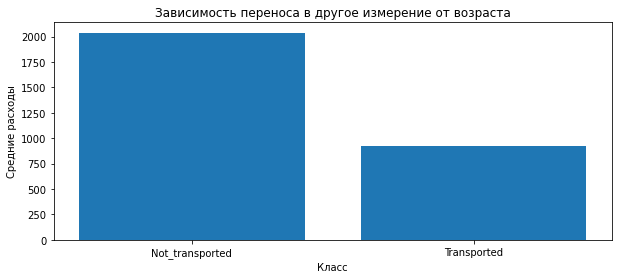

In [13]:
#Зависимость переноса в другое измерение от средних расходов 
graph_df['Sum'] = graph_df['RoomService'] + graph_df['FoodCourt'] + graph_df['ShoppingMall'] \
                                          + graph_df['Spa'] + graph_df['VRDeck']
plt.figure(figsize=(10, 4))
plt.bar(['Not_transported', 'Transported'], [graph_df[graph_df['Transported'] == 0]['Sum'].mean(),                                     graph_df[graph_df['Transported'] == 1]['Sum'].mean()])
plt.title('Зависимость переноса в другое измерение от возраста')
plt.ylabel('Средние расходы')
plt.xlabel('Класс');


Пассажиры с меньшими расходами переносились в другое измерение чаще

<h3 align='left'>Feature engeniring </h3>

In [14]:
#Создаем новые переменные
data['Sum'] = data['RoomService'] + data['FoodCourt'] + data['ShoppingMall'] + data['Spa'] + data['VRDeck'] #сумма расходов
def welfare_class_create(x):
    if x <= np.nanpercentile(data['Sum'], 50):
        return 'poor'
    elif x > np.nanpercentile(data['Sum'], 50) and x <= np.nanpercentile(data['Sum'], 75):
        return 'middle'
    else: return 'rich'

data['Welfare'] = data['Sum'].apply(lambda x: welfare_class_create(x))   #разделение на классы исходя из величины расходов

def age_class_create(x):
    if x <= 10:
        return '0-10'
    elif x > 10 and x <= 20:
        return '10-20'
    elif x > 20 and x <= 30:
        return '20-30'
    elif x > 30 and x <= 40:
        return '30-40'
    elif x > 40 and x <= 50:
        return '40-50'
    else: return '50+'

data['Age_class'] = data['Age'].apply(lambda x: age_class_create(x))  #разделение на классы исходя из возраста

In [15]:
# float_feat = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
# for i 

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12753 entries, 0 to 4276
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12753 non-null  object 
 1   HomePlanet    12753 non-null  object 
 2   CryoSleep     12753 non-null  int64  
 3   Cabin         12461 non-null  object 
 4   Destination   12753 non-null  object 
 5   Age           12753 non-null  float64
 6   VIP           12753 non-null  int64  
 7   RoomService   12753 non-null  float64
 8   FoodCourt     12753 non-null  float64
 9   ShoppingMall  12753 non-null  float64
 10  Spa           12753 non-null  float64
 11  VRDeck        12753 non-null  float64
 12  Name          12469 non-null  object 
 13  Transported   8476 non-null   object 
 14  Deck          12461 non-null  object 
 15  Num           12461 non-null  object 
 16  Side          12461 non-null  object 
 17  Group         12753 non-null  object 
 18  ID_in_group   12753 non-nul

<h3 align='left'>Подготовка данных</h3>

In [17]:
#Удаляем ненужные переменные, применяем преобразование One-Hot Encoding и приводим данные к разреженному формату
data = data.drop(['PassengerId', 'Num', 'Group', 'ID_in_group', 'Name', 'Transported', 'Cabin'], axis=1)
data = csr_matrix(pd.get_dummies(data))

In [18]:
data

<12753x34 sparse matrix of type '<class 'numpy.float64'>'
	with 124757 stored elements in Compressed Sparse Row format>

In [19]:
#Разделяем train, valid и test
X_train_full = data[:train_size,:]
X_test = data[train_size:,:]
X_train, X_valid, y_train, y_valid = train_test_split(
X_train_full, y_train_full, test_size=0.2, random_state=42)

<h1 align='center'>XGBoost</h1>

In [20]:
#Задаем диапазон гиперпараметров для поиска наилучших
params1 = {
        'min_child_weight': [1, 3, 5, 7, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': range(3, 20, 1)
        }

params2 = {
    'n_estimators': range(100, 2000, 5),
    'learning_rate': np.arange(0.01, 0.5, 0.01)
        
}

In [21]:
#Подбираем параметры на кросс-валидации
k = StratifiedKFold(n_splits=10, shuffle=True, random_state=17)
clf = XGBClassifier(n_estimators=200)
search = RandomizedSearchCV(clf, params1, cv=k, n_jobs=-1, random_state=17)
search.fit(X_train, y_train)

C:\Users\123\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:39:26] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=17, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=Non...
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None,
                                           reg_alpha=None, reg_lambda=None,
                                           scal

In [22]:
clf2 = XGBClassifier(**search.best_params_)
search2 = RandomizedSearchCV(clf2, params2, cv=k, n_jobs=-1, random_state=17)
search2.fit(X_train, y_train)

C:\Users\123\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:40:17] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=17, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=0.6,
                                           enable_categorical=False, gamma=5,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=5,
                                           min_c...
                                           verbosity=None),
                   n_jobs=-1,
                   param_distributions={'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
    

In [23]:
y_pred = search2.best_estimator_.predict(X_valid)
accuracy_score(y_valid, y_pred)

0.8066037735849056

In [24]:
clf_fin = XGBClassifier(**search2.best_params_, **search.best_params_, n_jobs=-1)
clf_fin.fit(X_train_full, y_train_full)

C:\Users\123\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:40:18] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6,
              enable_categorical=False, gamma=5, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.26, max_delta_step=0, max_depth=5,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=245, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1.0, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [25]:
y_pred = clf_fin.predict(X_test)
kaggle_sub(y_pred)
#accuracy 0.80360